## IMDb

Fast.ai has introduced a new module called fastai.text which replaces the torchtext library. Torchtext was used in our dl1 2018 course. The fastai.text module also supersedes the fastai.nlp library but retains many of the functions.

We also import HTML so that we can unescape HTML tags in data during tokenization

In [2]:
from fastai.text import *
import html

The BOS and FLD are custom tokens to be inserted into the text data during tokenization.
BOS is beginning of stream, which means one stream(block of text like a movie review) has ended and another begun
FLD is used if the text data has many fields. In the case of IMDB, we have only one text field, the review itself. So this new token might not have a lot of value, but we still insert it anyway.

There are more tokens introduced like t_up which is inserted into the text data in front of fully UP-CASE words (could mean shouting or emphasis). This saves us the information loss with lower() or also not having to learn 2 tokens for the same word - i.e. the lower and upper case versions. t_up tells the model that the following word was originally UP-CASED but i've downcased it for you. * more details below in the tokenizer section *

You also need to download IMDB large movie reviews from this site: http://ai.stanford.edu/~amaas/data/sentiment/
Direct link : [Link](http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz) and untar it into the PATH location. Path is pathlib which makes directory traveral a breeze.

In [4]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

PATH=Path('data/aclImdb/')

## Standardize format

We create 2 paths:

**CLAS** is for the classifier model and data & 
**LM** is for the language model and data

In [5]:
CLAS_PATH=Path('data/imdb_clas/')
CLAS_PATH.mkdir(exist_ok=True)

LM_PATH=Path('data/imdb_lm/')
LM_PATH.mkdir(exist_ok=True)

The imdb dataset has 3 classes. positive, negative and unsupervised(sentiment is unknown). The README file in the imdb corpus directory explains how the data is laid out. 

The get_texts fn is used to read the step into the directory for each class(p,n,u) and read all the files and store them as entries in an array called texts. We also create another array called labels and fill it up with 0 for pos, 1 for neg and 2 for unsup reviews.

In [7]:
CLASSES = ['neg', 'pos', 'unsup']

def get_texts(path):
    texts,labels = [],[]
    for idx,label in enumerate(CLASSES):
        for fname in (path/label).glob('*.*'):
            texts.append(fname.open('r').read())
            labels.append(idx)
    return np.array(texts),np.array(labels)

We use get_texts fn to read all the training reviews and test reviews

In [8]:
trn_texts,trn_labels = get_texts(PATH/'train')
val_texts,val_labels = get_texts(PATH/'test')

There are 75k training reviews(12.5k pos, 12.5k neg, 50k unsup)

There are 25k training reviews(12.5k pos, 12.5k neg & no unsup)

In [11]:
len(trn_texts),len(val_texts)

(75000, 25000)

In [12]:
col_names = ['labels','text'] # setup column names because pandas dataframe will ask for it

Use a random permutation np array to shuffle the text reviews.

In [15]:
np.random.seed(42) # the random seed ensures that the next 2 random permutations result in the same order.
trn_idx = np.random.permutation(len(trn_texts)) # Create an array of numbers for randomly shuffling training review texts
val_idx = np.random.permutation(len(val_texts)) # Create an array of numbers for randomly shuffling test review texts

In [21]:
print (trn_idx[:20],'\n', val_idx[:20]) # see first 20 indices

[26837  2592 18359 73292 60127 71737 26473  1040 32622 44679 17262 65288  9908 70558  5897 46462  2679 30356
 36732 48199] 
 [23481 13606 13639  1170  6803 18371 12360 13547 13215 21187  6251 23086  4688 15580 11756  2906 20742  2455
  1454 17650]


You can pass the whole random array as an index to the texts and store the shuffled text in an array.

In [22]:
trn_texts = trn_texts[trn_idx] #use trn index
val_texts = val_texts[val_idx] # ditto for val texts

trn_labels = trn_labels[trn_idx] # use same trn idx to get labels shuffled in same order
val_labels = val_labels[val_idx] # ditto for val labels

All the training and text files/labels should be shuffled now and ready to get loaded into a pandas DF.

In [26]:
len(trn_texts),len(trn_labels),len(val_texts),len(val_labels) #75k 75k 25k 25k

(75000, 75000, 25000, 25000)

The pandas dataframe is used to store text data in a newly evolving standard format of label followed by text columns. This was influenced by a paper by Yann LeCun. Fastai adopts this new format. In the case of IMDB, there is only one text column.

In [29]:
df_trn = pd.DataFrame({'text':trn_texts, 'labels':trn_labels}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':val_labels}, columns=col_names)
df_val.head()

,labels,text
0,0,Dr Steven Segal saves the world from a deadly ...
1,1,"Cleopatra 2525 is a very funny, entertaining s..."
2,1,I was recently at a sleepover birthday party w...
3,0,Why? Why? Why on earth no one tells the truth ...
4,0,"Unlike most reviewers here, I hated this movie..."


Save the dataframe as CSV files in the CLAS path. Since CLAS is for the classifier data, we discard the unsup training reviews. So in CLAS_PATH/'train.csv' you will see only 1(pos) and 0(neg) reviews. The CSV mirrors the DF structure.

All 3 classes are stored in a classes.txt file.

In [30]:
df_trn[df_trn['labels']!=2].to_csv(CLAS_PATH/'train.csv', header=False, index=False)
df_val.to_csv(CLAS_PATH/'test.csv', header=False, index=False)

(CLAS_PATH/'classes.txt').open('w').writelines(f'{o}\n' for o in CLASSES)

Now that the Classifier data is stored, we will not need it for a while. We need to get a good language model for IMDB first.

Let's start by creating the data for the Language Model(LM). The LM's goal is to learn the structure of the english language. It learns language by trying to predict the next word given a set of previous words(ngrams). We really don't need to classify reviews as pos, neg etc. and labels can be ignored because we are not classifying anything in the LM.
(*The labels are only used in the classifier model we will see later in this notebook.*)

The LM can benefit from all the textual data and there is no need to exclude the unsup/unclassified movie reviews.

We first concat all the train(pos/neg/unsup = **75k**) and test(pos/neg=**25k**) reviews into a big chunk of **100k** reviews. And then we use sklearn splitter to divide up the 100k texts into 90% training and 10% validation sets. *Again, the goal of the LM is to learn english by trying to predict words*

In [31]:
trn_texts,val_texts = sklearn.model_selection.train_test_split(
    np.concatenate([trn_texts,val_texts]), test_size=0.1)

In [34]:
len(trn_texts), len(val_texts) # 90k to train and 10k to predict prose

(90000, 10000)

In [36]:
trn_texts[0] # print first moview review from the training set

'I really like the show and the virile "manliness" and cool humor exhibited by Darren Gavin. I\'m sorry he has passed on. Some feminists might find the humor demeaning, but we have to remember it was mid-60s. My only criticism is that it was mainly filmed in Hollywood except for a very few exterior shots of New York. It is very Californiaish, particularly in some outdoors shots which are definitely not New York countryside. That\'s a failing if you really want authenticity about a New York detective, particularly when you compare it to "Naked City" which was filmed on the streets of the city. Luckily some of the episodes are now on DVD. (I wish there would be more of these classic series on TV.)'

Since we now have a standard format of textual data, we need to store the reviews again in train.csv(90k) and test.csv(10k) in the LM path. This is just like the CLAS path files we stored earlier. We put labels first and then the text columns. Since we don't have labels in the LM case, we just put 0s in the label column.

In [39]:
df_trn = pd.DataFrame({'text':trn_texts, 'labels':[0]*len(trn_texts)}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':[0]*len(val_texts)}, columns=col_names)

df_trn.to_csv(LM_PATH/'train.csv', header=False, index=False) #save LM train.csv
df_val.to_csv(LM_PATH/'test.csv', header=False, index=False) #save LM test.csv

df_trn.head() # print few rows from the pandas dataframe - labels are just 0.

,labels,text
0,0,"I really like the show and the virile ""manline..."
1,0,Michael Pitt can't act PLEASE make him stop tr...
2,0,"Misty Ayers had a smoking body, and that's all..."
3,0,Which do you think the average person would kn...
4,0,"This ground breaking movie, much like the grou..."


## Language model tokens

The previous section was all about storing the textual data into LM and CLAS paths in a standard format we have adopted at fastai. In this section, we will start cleaning up the messy text. There are 2 main activities we need to perform:

1. Clean up extra spaces, tab chars, new ln chars and other characters and replace them with standard ones
2. Use the awesome [spacy](http://spacy.io) library to tokenize the data. Since spacy does not provide a parallel/multicore version of the tokenizer, the fastai library adds this functionality. This parallel version uses all the cores of your CPUs and runs much faster than the serial version of the spacy tokenizer.

Tokenization is the process of splitting the text into separate tokens so that each token can be assigned a unique index. This means we can convert the text into pure numbers our models can use. *the indexes are integers but our models like to use real numbers - we will see how to convert these indexes to real numbers later.*

A big issue with the tokenization process is that it is memory intensive - we use a chunksize of 24k to process the data in chunks.

In [52]:
chunksize=24000

The fixup fn standardizes text and unescapes HTML tags. The get_texts fn uses the parallel tokenizer and creates the tokens in tok.

In [41]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

In [42]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = texts.apply(fixup).values.astype(str)

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

In [43]:
def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i) # print out the loop number for each chunk of DF processed. chunksize is set above.
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [54]:
df_trn = pd.read_csv(LM_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(LM_PATH/'test.csv', header=None, chunksize=chunksize)

In [55]:
#Since we have 24k chunks you should see the loop run for each 24k chunk.
#chunksize=100000 # Do this if you have enough RAM.
tok_trn, trn_labels = get_all(df_trn, 1) # 4 loops (0,1,2,3) for 90k of training data
tok_val, val_labels = get_all(df_val, 1) # 1 loop (0) for 10k of training data

0
1
2
3
0


Make a temporary directory and store all the tokenized data as numpy arrays that can be loaded up in the future.

In [56]:
(LM_PATH/'tmp').mkdir(exist_ok=True)

In [57]:
np.save(LM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val.npy', tok_val)

In [115]:
#Check saved files
!ls $LM_PATH/*

data/imdb_lm/test.csv  data/imdb_lm/train.csv

data/imdb_lm/tmp:
itos.pkl  tok_trn.npy  tok_val.npy  trn_ids.npy  val_ids.npy


In [66]:
len(tok_trn) # 90k training data text properly tokenized.

90000

In [71]:
tok_trn[100][:10] #101th review shown as tokens - only first 10 tokens are shown.

['\n',
 'xbos',
 'xfld',
 '1',
 'costner',
 "'s",
 'films',
 'continue',
 'without',
 'heart']

In [73]:
' '.join(tok_trn[100]) #101th review in training set - shown as tokenized text.

"\n xbos xfld 1 costner 's films continue without heart or soul . each is an appendage to the only film he ever made . this episode is more properly judged in the genre of videos , as this film substitutes any plot or character development , and certainly any acting for bland cinematography and overdone music . discard comments regarding sexism and ignore comparisons to tombstone , i feel sorry for him and his costars , some of whom actually deliver strong , believable performances . doc holliday is always entertaining . i was particularly saddened that the writers chose to trivialize the friendship between doc and wyatt by basing it upon a few meaningful looks and friendly handshakes . showing doc save wyatt 's life would have made for better watching and historical accuracy . and may i say , i love this legend ..."

In the future, you can avoid the tokenization and cleaning process if you have stored the data in numpy files. You can simply load them up!

In [74]:
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val.npy')

We can use python's Counter class to get the counts for each token in our data set. This can be useful to see which tokens/words are most used. Usually in normal text like english movie reviews, you'll find the words *a,the,and,of* etc. as the most frequent tokens.

In [75]:
freq = Counter(p for o in tok_trn for p in o) # for each object in tok_trn, take out the pieces. And foe each piece, run a count.
freq.most_common(25) # display in descending order of count the top 25 tokens. 

[('the', 1209774),
 ('.', 992434),
 (',', 985208),
 ('and', 587218),
 ('a', 583337),
 ('of', 524995),
 ('to', 485571),
 ('is', 393545),
 ('it', 341509),
 ('in', 337883),
 ('i', 307894),
 ('this', 270449),
 ('that', 261016),
 ('"', 237586),
 ("'s", 221225),
 ('-', 187707),
 ('was', 180504),
 ('\n\n', 179085),
 ('as', 166306),
 ('with', 159178),
 ('for', 158681),
 ('movie', 157557),
 ('but', 150450),
 ('film', 144288),
 ('you', 124032)]

The *vocab* is the **unique set of all tokens** in our dataset. The vocab provides us a way for us to simply replace each word in our datasets with a unique integer called an index. This way we can convert textual data into numbers that our models can use. You might recall that an embedding layer is sometimes used to convert these indexes to real numbers which neural nets prefer.

In a large corpus of data one might find some rare words which are only used a few times in the whole dataset. In such cases, there is no point wasting time, trying to learn meaningful patterns out of them and we can choose to discard them. Here we have set a minimum frequency of occurence to 2 times. If any token does not appear atleast twice in our full dataset, we will set it to a token called \_unk\_

It has been observed by NLP practicioners that a maximum vocab of 60k usually yields good results for classification tasks. So we set maz_vocab to 60000.

In [76]:
max_vocab = 60000
min_freq = 2

We create a mapping of the vocab indexes so that we can represent all of our corpus data as a big set of integers. We call this mapping itos. itos is created descending order of frequency of our corpus tokens. Since we set max_vocab to 60k, we have itos length as 60000. In addition we add a couple more tokens for unknown and pad characters.

In [97]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

In [98]:
itos[:10] #here are the top 10 tokens from the itos mapping

['_unk_', '_pad_', 'the', '.', ',', 'and', 'a', 'of', 'to', 'is']

60k most frequent words of the corpus in descending order + \_unk\_ & \_pad\_ tokens make up our vocab of size 60002

In [99]:
len(itos)

60002

Now that we have an itos, we can quickly create a reverse mapping called stoi which is useful to lookup the index of a given token. stoi also has the same number of elements as itos.

In [101]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

We use a high performance container called [collections.defaultdict](https://docs.python.org/2/library/collections.html#collections.defaultdict) to store our stoi mapping. It looks and feels like a typical dictionary in python, but is immune to missing values. 

Here are 10 elements in stoi.

In [107]:
list(stoi)[:10] # displaying 10 elements after casting as a list.

['_unk_', '_pad_', 'the', '.', ',', 'and', 'a', 'of', 'to', 'is']

We now convert our 90k training and 10k test tokens into integer indexes.

In [151]:
stoi['_pad_'] #get the index of the _pad_ token

1

In [150]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [128]:
trn_lm.shape,val_lm.shape #np arrays after tokenization and indexing.

((90000,), (10000,))

In [162]:
str(trn_lm[0]) #The first training movie review expressed purely as integer indexes - numericalized version.

'[40, 41, 42, 39, 12, 82, 52, 2, 140, 5, 2, 20552, 15, 36157, 15, 5, 602, 469, 13103, 46, 7364, 13699, 3, 12, 166, 771, 34, 59, 2186, 28, 3, 64, 17309, 252, 185, 2, 469, 15219, 4, 24, 89, 36, 8, 418, 10, 18, 39743, 3, 76, 80, 2840, 9, 14, 10, 18, 1430, 760, 11, 361, 565, 22, 6, 69, 189, 6246, 688, 7, 179, 786, 3, 10, 9, 69, 0, 4, 612, 11, 64, 12880, 688, 79, 33, 423, 32, 179, 786, 4424, 3, 14, 16, 6, 4198, 62, 26, 82, 203, 5754, 58, 6, 179, 786, 1210, 4, 612, 67, 26, 1723, 10, 8, 15, 1278, 515, 15, 79, 18, 760, 28, 2, 1817, 7, 2, 515, 3, 3808, 64, 7, 2, 770, 33, 165, 28, 31, 288, 3, 30, 12, 662, 53, 72, 37, 68, 7, 150, 389, 226, 28, 264, 3, 27]'

In [148]:
itos_arr = np.array(itos)
itos_arr[trn_lm[0]] # showing the first movie review as a reverse lookup of trn_lm[0] from itos

array(['\n', 'xbos', 'xfld', '1', 'i', 'really', 'like', 'the', 'show', 'and', 'the', 'virile', '"',
       'manliness', '"', 'and', 'cool', 'humor', 'exhibited', 'by', 'darren', 'gavin', '.', 'i', "'m",
       'sorry', 'he', 'has', 'passed', 'on', '.', 'some', 'feminists', 'might', 'find', 'the', 'humor',
       'demeaning', ',', 'but', 'we', 'have', 'to', 'remember', 'it', 'was', 'mid-60s', '.', 'my', 'only',
       'criticism', 'is', 'that', 'it', 'was', 'mainly', 'filmed', 'in', 'hollywood', 'except', 'for', 'a',
       'very', 'few', 'exterior', 'shots', 'of', 'new', 'york', '.', 'it', 'is', 'very', '_unk_', ',',
       'particularly', 'in', 'some', 'outdoors', 'shots', 'which', 'are', 'definitely', 'not', 'new', 'york',
       'countryside', '.', 'that', "'s", 'a', 'failing', 'if', 'you', 'really', 'want', 'authenticity',
       'about', 'a', 'new', 'york', 'detective', ',', 'particularly', 'when', 'you', 'compare', 'it', 'to',
       '"', 'naked', 'city', '"', 'which', 'was', 'f

 We now save our indexed data as numpy arrays. Saving the array can save us time in the future and we can load the datasets.
 We also save our itos mapping because we will be using it in the future for lookups.

In [110]:
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

In [116]:
#Check the saved files
!ls $LM_PATH/*

data/imdb_lm/test.csv  data/imdb_lm/train.csv

data/imdb_lm/tmp:
itos.pkl  tok_trn.npy  tok_val.npy  trn_ids.npy  val_ids.npy


**NOTE: For the time being, I'm sacrificing accuracy to check the LM - So, only 100 rows are used to in the lm dataset - and sent to the dataloader**

In [154]:
#trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
#val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')

#For quick notebook validation - load back only 100 training and 100 validation reviews from our LM npys.
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')[:100]
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')[:100]
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))a

In [156]:
vs=len(itos) #vocab size
vs,len(trn_lm)

(60002, 100)

## wikitext103 conversion

We are now going to build a language model for the IMDB corpus. We could start from scratch and try to learn the structure of the english language. But we use a technique called transfer learning to make this process easier. In transfer learning (a fairly recent idea for NLP) a pre-trained LM that has been trained on a large generic corpus(_like wikipedia articles_) can be used to transfer it's knowledge to a target LM and the weights can be fine-tuned. The source and target LMs should have data in the same  natural language(_english in our case_).

Our source LM is the wikitext103 LM created by Stephen Merity @ Salesforce research. [Link to dataset](https://www.salesforce.com/products/einstein/ai-research/the-wikitext-dependency-language-modeling-dataset/)
The language model for wikitext103 has already been created for us using the AWD LSTM model and the weights can be downloaded here: [Link](http://files.fast.ai/models/wt103/)

Our target LM is the IMDB LM. 

In [163]:
# use wget to download the files from the fast.ai link
# ! wget -nH -r -np http://files.fast.ai/models/wt103/

The pre-trained LM weights have been created with an embedding size of 400, 1150 hidden units and just 3 layers. _The model is based on AWD LSTM seen in lesson 4 and contains lot of droput values placed strategically throughout the model._

We need to match these values (emedding size, number of hidden and total layers) with the target IMDB LM so that the weights can be loaded up.

In [164]:
em_sz,nh,nl = 400,1150,3

The downloaded pre-trained model weights are placed in a separate directory called PRE_PATH.

In [166]:
PRE_PATH = PATH/'models'/'wt103'
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

In [167]:
PRE_PATH

PosixPath('data/aclImdb/models/wt103')

We load the weights using torch.load that returns an ordered dictionary. The odict contains the number of elements matching the number of layers we have in the model.

In [171]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

In [172]:
wgts.keys()

odict_keys(['0.encoder.weight', '0.encoder_with_dropout.embed.weight', '0.rnns.0.module.weight_ih_l0', '0.rnns.0.module.bias_ih_l0', '0.rnns.0.module.bias_hh_l0', '0.rnns.0.module.weight_hh_l0_raw', '0.rnns.1.module.weight_ih_l0', '0.rnns.1.module.bias_ih_l0', '0.rnns.1.module.bias_hh_l0', '0.rnns.1.module.weight_hh_l0_raw', '0.rnns.2.module.weight_ih_l0', '0.rnns.2.module.bias_ih_l0', '0.rnns.2.module.bias_hh_l0', '0.rnns.2.module.weight_hh_l0_raw', '1.decoder.weight'])

As you can see, there are weights and biases for many encoder, rnn layers. We can also see weights for a decoder (_last key_). But as you'll see, we are mainly interested in the encoders - the encoders are the layers which contain the knowledge of "english language structure" that we want to eventually use in our classifier(_last section of this notebook_).

In [177]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0) # calculate mean of encoder layer 0 weights.

We calculate the mean of the layer0 encoder weights. This can be used to assign weights to unknown tokens when we transfer to target IMDB LM.

In [179]:
row_m.shape, row_m[:10] #the mean has same size as the embedding. Shown are first 10 values

((400,),
 array([-0.0183 , -0.13826,  0.01438, -0.01285,  0.00407,  0.01944,  0.01149, -0.13282, -0.02295, -0.01722],
       dtype=float32))

Before we try to transfer the knowledge from wikitext to IMDB model, we need to match up the vocab words and their indexes. We load the wikitext103 tokens into a list called itos2 and use it to create the stoi2 reverse mapping. 

We use the defaultdict container once again, that gives us the option of creating missing key values on lookup. We choose to initialize missing token lookups to -1. There shouldn't be any -1 when we start, but when we try to find IMDB words in wikitext103 stoi2, we could find some missing words. At that point, stoi2 will automatically set the values for those missing tokens to -1.

In [190]:
itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

In [191]:
# the wikitext103 contains 238462 tokens. 
#Here are 10 of them. 'create' seems to be the 1000th most common word in wikitext103
len(itos2),itos2[999:1009]

(238462,
 ['create',
  '1998',
  'upper',
  'longer',
  'soldiers',
  'your',
  'jackson',
  'done',
  'trade',
  'fort'])

Next we start creating an embedding matrix for the target IMDB LM. The embedding matrix is of size (vocab size, embedding size) which is common between both LMs.

We initialize the embedding matrix with a zeros np array and start filling it up by a cross-lookup between IMDB and wikitext103 tokens. We take a token from itos(IMDB), and do a reverse lookup in stoi2(Wikitext103). If it is found, we take the weights of that token and plug them into our embedding matrix. If we hit a missing token (that's in IMDB and not wikitext) stoi2 will automatically set it to -1. So we check for those numbers less than 0(missing tokens) and initialize them with mean weights(*row_m calculated earlier*).

*The missing token embedding weights can be initialized randomly as well but the model might find it easier to tune weights from the mean point.*

While the embedding layer tokens are initialized with well trained weights from wikitext, the missing token weights need to be tuned well before use.

In [221]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

In [222]:
new_w.shape # our new IMDB embedding matrix is of IMDB vocab size X emb_sz

(60002, 400)

We now overwrite the weights into the wgts odict, by first converting np arrays to tensors. If we don't make copies of NP arrays before assignment the torch tensors will share memory space and won't train well.

*The decoder module, which we will explore in detail is also loaded with the same weights due to an idea called weight tying. Weight tying is a concept of using the same set of weights for multiple parameters by having the model point to the same memoray locations where the weights are stored. This usually results is a lot less parameters to train and speeds up the process. Sometimes, it is beneficial to tie weights across layers to have more control over the activations from those layers.*

In [224]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

In [226]:
# Check tensor size of named element weights
wgts['1.decoder.weight'].shape

torch.Size([60002, 400])

Now that we have the weights prepared, we are ready to create and start training our new IMDB language pytorch model!

## Language model

It is fairly straightforward to create a new language model using the fastai library. Like every other lesson, our model will have a backbone and a custom head. The backbone in our case is the IMDB LM pre-trained with wikitext and the custom head is a linear classifier. In this section we will focus on the backbone LM and the next section will talk about the classifier custom head.

We start by initializing the following core settings for our model: 
Weight decay, back prop through time (*the approximate number of tokens we read in each batch to predict the target token*), batch size (*the number of inputs processed in each mini-batch*) and the optimizer we want to use.

bptt (*also known traditionally in NLP LM as ngrams*) in fastai LMs is approximated to a std. deviation around 70, by perturbing the sequence length on a per-batch basis. This is akin to shuffling our data in computer vision, only that in NLP we cannot shuffle inputs and we have to maintain statefulness. 

Since we are predicting words using ngrams, we want our next batch to line up with the end-points of the previous mini-batch's items. batch-size is constant and but the fastai library expands and contracts bptt each mini-batch using a clever stochastic implementation of a batch, whose original credits are attributed to [Smerity](https://twitter.com/jeremyphoward/status/980227258395770882)!

In [228]:
wd=1e-7 #weight decay
bptt=70 # we mention 70 but fastai uses some approximate value around 70
bs=100 #batch size
opt_fn = partial(optim.Adam, betas=(0.8, 0.99)) # use adam optimizer with low betas - RNNs tend to work better with this setting

The goal of the LM is to learn to predict a word/token given a preceeding set of words(tokens). We take all the movie reviews in both the 90k training set and 10k validation set and concatenate them to form long strings of tokens. In fastai, we use the `LanguageModelLoader` to create a data loader which makes it easy to create and use bptt sized mini batches. The  `LanguageModelLoader` takes a concatenated string of tokens and returns a loader.

Then we chuck both those training and validation loaders into a model data object. We have a special class for LMs called `LanguageModelData`. Using this class, we can conveniently ask the fastai library to automatically give us the model itself.

In [229]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

**Definition of the `LanguageModelLoader` class**: Return an iterator of bs X bptt by batchifying a train/validation or test set 

```python
Init signature: LanguageModelLoader(nums, bs, bptt, backwards=False)
Docstring:      <no docstring>
Source:        
class LanguageModelLoader():
    def __init__(self, nums, bs, bptt, backwards=False):
        self.bs,self.bptt,self.backwards = bs,bptt,backwards
        self.data = self.batchify(nums)
        self.i,self.iter = 0,0
        self.n = len(self.data)

    def __iter__(self):                #Iteratively returns approximately mini batch of size bs X (approx bptt)
        self.i,self.iter = 0,0
        while self.i < self.n-1 and self.iter<len(self):
            bptt = self.bptt if np.random.random() < 0.95 else self.bptt / 2.
            seq_len = max(5, int(np.random.normal(bptt, 5)))
            res = self.get_batch(self.i, seq_len)
            self.i += seq_len
            self.iter += 1
            yield res 

    def __len__(self): return self.n // self.bptt - 1

    def batchify(self, data):         #breaks up the whole dataset into bs number of chunks
        nb = data.shape[0] // self.bs
        data = np.array(data[:nb*self.bs])
        data = data.reshape(self.bs, -1).T
        if self.backwards: data=data[::-1]
        return T(data)

    def get_batch(self, i, seq_len):
        source = self.data
        seq_len = min(seq_len, len(source) - 1 - i)
        return source[i:i+seq_len], source[i+1:i+1+seq_len].view(-1)
File:           ~/fastai2/fastai/courses/dl2/fastai/text.py
Type:           type


```




**Definition of the `LanguageModelData` class** : Initialize core settings and retrieve model from `get_language_model` and return it as using `RNN_Learner`.

The magic happens the `get_model` fn where the `get_language_model` fn is used to return a `SequentialRNN` model.
In the SequentialRNN model, an RNN_Encoder layer is instantiated using the parameters provided. This is followed by the creation of a LinearDecoder layer. Also by default (i.e. tie_weights = True), the embedding matrix used in the RNN_Encoder is used to  instantiate the weights for the LinearDecoder layer. As a final step, the learner which gets returned is a special type called `RNN_Learner` where the loss fn is set to cross-entropy. We need this loss to make sure the LM effectively learns to predict subsequent words.

    The SequentialRNN layer is the native torch's Sequential wrapper that puts the RNN_Encoder and
    LinearDecoder layers sequentially in the model.
```python
Init signature: LanguageModelData(path, pad_idx, nt, trn_dl, val_dl, test_dl=None, bptt=70, backwards=False, **kwargs)
Docstring:      <no docstring>
Source:        
class LanguageModelData():
    def __init__(self, path, pad_idx, nt, trn_dl, val_dl, test_dl=None, bptt=70, backwards=False, **kwargs):
        self.path,self.pad_idx,self.nt = path,pad_idx,nt
        self.trn_dl,self.val_dl,self.test_dl = trn_dl,val_dl,test_dl

    def get_model(self, opt_fn, emb_sz, n_hid, n_layers, **kwargs):
        m = get_language_model(self.nt, emb_sz, n_hid, n_layers, self.pad_idx, **kwargs)
        model = LanguageModel(to_gpu(m))
        #return RNN_Learner(self, nn.DataParallel(model), opt_fn=opt_fn)
        return RNN_Learner(self, model, opt_fn=opt_fn)
File:           ~/fastai2/fastai/courses/dl2/fastai/text.py
Type:           type
```

In [239]:
??RNN_Learner

We setup the dropouts for the model - these values have been chosen after experimentation. If you need to update them for custom LMs, you can change the weighting factor (0.7 here) based on the amount of data you have. For more data, you can reduce dropout factor and for small datasets, you can reduce overfitting by choosing a higher dropout factor. *No other dropout value requires tuning*

In [236]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7 #setup dropout values and control them using a weighting factor: 0.7 here

Now that we have a model data object for our IMDB LM, it is a straightforward process to get the model from it and name it `learner`. One of the first things to tune in the encoder(and the decoder because of default weight tying) is the last embedding layer. This is mainly done so that the missing tokens initialized with mean weights get tuned properly. So we freeze everything except the last layer.

In [255]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1) # Freeze until the last embedding layer
#learner.unfreeze()

As you can see, the learner is a typical pytorch module with an (0)encoder and a (1)decoder.

The encoder contains the embedding layer and 3 hidden LSTM layers. The decoder is a linear layer with *vocab_size* number of tokens for predicting output probabilities of each of the tokens in the vocab.

In [256]:
learner #Show the full model

SequentialRNN(
  (0): RNN_Encoder(
    (encoder): Embedding(60002, 400, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(60002, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(400, 1150, dropout=0.105)
      )
      (1): WeightDrop(
        (module): LSTM(1150, 1150, dropout=0.105)
      )
      (2): WeightDrop(
        (module): LSTM(1150, 400, dropout=0.105)
      )
    )
    (dropouti): LockedDropout(
    )
    (dropouths): ModuleList(
      (0): LockedDropout(
      )
      (1): LockedDropout(
      )
      (2): LockedDropout(
      )
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=60002, bias=False)
    (dropout): LockedDropout(
    )
  )
)

In [257]:
learner.model.state_dict() # Let's check our model weights

OrderedDict([('0.encoder.weight', 
               0.0676 -0.0510  0.0617  ...  -0.0848  0.0321  0.0716
               0.0672  0.0265  0.0298  ...   0.0638  0.0968 -0.0329
              -0.0119  0.0022 -0.0030  ...   0.0645 -0.0806  0.0679
                        ...             ⋱             ...          
               0.0074 -0.0083  0.0296  ...   0.0371  0.0334 -0.0621
              -0.0100  0.0115  0.0054  ...  -0.0695  0.0668 -0.0989
               0.0970  0.0534 -0.0448  ...   0.0264 -0.0076 -0.0402
              [torch.FloatTensor of size 60002x400]),
             ('0.encoder_with_dropout.embed.weight', 
               0.0676 -0.0510  0.0617  ...  -0.0848  0.0321  0.0716
               0.0672  0.0265  0.0298  ...   0.0638  0.0968 -0.0329
              -0.0119  0.0022 -0.0030  ...   0.0645 -0.0806  0.0679
                        ...             ⋱             ...          
               0.0074 -0.0083  0.0296  ...   0.0371  0.0334 -0.0621
              -0.0100  0.0115  0.0054  ..

In [258]:
??learner.model.load_state_dict()

We now copy our weights from the `wgts` state dictionary using the fastai `load_state_dict` function. It copied the parameters and buffers from `wgts` into our model's module and its descendants. The attribute`strict` is ``True`` by default and it forces the the keys of `wgts` to exactly match the keys returned by our module's `state_dict()` function.

In [259]:
learner.model.load_state_dict(wgts) # Load the weights into our learner model

We set learning rates and fit our IMDB LM. We first run one epoch to tune the last layer which contains the embedding weights. This should help the missing tokens in the wikitext103 learn better weights.

In [260]:
lr=1e-3
lrs = lr

In [32]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy               
    0      5.602066   5.413144   0.218776  



[5.413143873214722, 0.21877604166666667]

Note that we print out accuracy and keep track of how often we end up predicting the target word correctly. While this is a good metric to check, it is not part of our loss function as it can get quite bumpy. We only minimize cross-entropy loss in the LM.

The exponent of the cross-entropy loss is called the perplexity of the LM. A low perplexity is a potential indicator of a good LM. If an LM is perplexed, it cannot speak good english.

In [ ]:
learner.save('lm_last_ft') # save last layer fit model

In [ ]:
learner.load('lm_last_ft') # load last layer fit model in future

We now unfreeze the model layers and get ready to fine tune some more.

In [ ]:
learner.unfreeze()

In [36]:
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

epoch      trn_loss   val_loss   accuracy               
    0      5.583637   6.30935    0.194163  



In [ ]:
learner.sched.plot()

In [38]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15)

epoch      trn_loss   val_loss   accuracy               
    0      5.536444   5.312485   0.223434  
    1      5.459926   5.120803   0.230434               
    2      5.323185   5.0591     0.229125               
    3      5.192071   5.010774   0.23125                
    4      5.074899   4.98609    0.231264               
    5      4.982038   4.949386   0.238163               
    6      4.884302   4.977661   0.23335                
    7      4.792179   4.95419    0.239158               
    8      4.704118   5.017949   0.231487               
    9      4.623066   5.017501   0.229992               
    10     4.549517   5.029907   0.231253               
    11     4.478839   5.049689   0.229848               
    12     4.422343   5.052155   0.229095               
    13     4.362847   5.062611   0.230302               
    14     4.315576   5.065027   0.229792               



[5.065026760101318, 0.22979234616220917]

We save the trained model weights and separately save the encoder part of the LM model as well. This will serve as our backbone in the classification task model.

In [ ]:
learner.save('lm1')

In [ ]:
learner.save_encoder('lm1_enc')

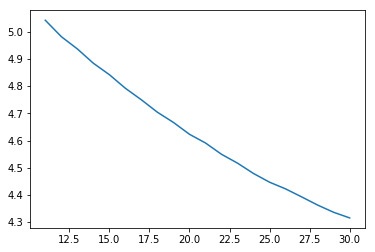

In [41]:
learner.sched.plot_loss()

## Classifier tokens

The classifier model is basically a linear layer custom head on top of the LM backbone. Before we create the classifier model and train it, we need to setup the data. 

Setting up the classifier data is similar to the LM data setup except that we cannot use the unsup movie reviews this time. In the LM, our goal was to learn english and the unsup reviews were used. Now, with actual pos/neg labels coming into play we discard the unsup reviews and use only the pos/neg ones.

We read the original train and test CSV files we had in the `CLAS_PATH` saved and perform the same sequence of steps to get the tokens, numericalized arrays and the `itos` and `stoi` mappings.

In [ ]:
# Create dataframes
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/'test.csv', header=None, chunksize=chunksize)

In [43]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
0
1


In [ ]:
# Save the numericalized data as npy arrays for future quick loads
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)

np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)

In [262]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')

In [263]:
# Create the itos mapping and stoi reverse mapping for tokens in the IMDB vocab.
itos = pickle.load((LM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

In [ ]:
# Get final data for classifier model
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

In [ ]:
np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)

At this point we have training data for the classifier model in `trn_clas` and validation data in `val_clas`.

## Classifier

Now we can create our final model, a classifier which is really a custom linear head over our trained IMDB backbone. The steps to create the classifier model are similar to the ones for the LM.

We first pickup the data and labels for creating the new modeldata object.

In [ ]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

In [ ]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

You can pick a batch size that you can comfortably fit into memory while training the classifier.

In [ ]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 48

In [ ]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

In the classifier, unlike LM, we need to read a movie review at a time and ;earn to predict the it's sentiment as pos/neg. We do not deal with equal bptt size batches, so we have to pad the sequences to the same length in each batch. Now, some movie reviews (like my documentation) can be quite lengthy and will result in the rest of the batch getting padded like crazy. To avoid this, a cool trick called the sortish sampler was invented by, wait for it, [@Smerity](https://twitter.com/Smerity) and [@jekbradbury](https://twitter.com/jekbradbury)

The sortishSampler approximately sorts in ascending order of sequence length the movie reviews so that we create batches where similar sized reviews get bundled into mini-batches. This cuts down the overall number of padding tokens the classifier ends up seeing.

In [ ]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [ ]:
# part 1
dps = np.array([0.4, 0.5, 0.05, 0.3, 0.1])

In [ ]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.5

In [ ]:
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [ ]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

The `RNN_Learner` is the learner class with the same encoder as our LM but a pooling linear classifier as the decoder(which gets trained more, while the LM encoder is slightly trained in the end after unfreezing).

In [ ]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy]

In [ ]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [ ]:
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [ ]:
wd = 1e-7
wd = 0
learn.load_encoder('lm1_enc')

In [ ]:
learn.freeze_to(-1)

 79%|███████▉  | 822/1042 [1:03:47<17:04,  4.66s/it, loss=1.99] 

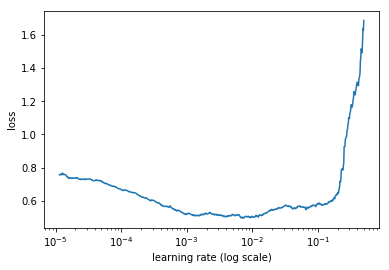

In [64]:
learn.lr_find(lrs/1000)
learn.sched.plot()

In [ ]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

In [ ]:
learn.save('clas_0')

In [ ]:
learn.load('clas_0')

In [ ]:
learn.freeze_to(-2)

In [69]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                        
    0      0.369499   0.29496    0.875496  



[0.29495994311948653, 0.8754958413307742]

In [ ]:
learn.save('clas_1')

In [ ]:
learn.load('clas_1')

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit(lrs, 1, wds=wd, cycle_len=14, use_clr=(32,10))

epoch      trn_loss   val_loss   accuracy                         
    0      0.346185   0.244749   0.901056  
    1      0.263001   0.214615   0.916787                         
    2      0.244726   0.195925   0.923664                         
    3      0.182181   0.189529   0.928399                         
 63%|██████▎   | 661/1042 [2:11:29<1:15:47, 11.93s/it, loss=0.142]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



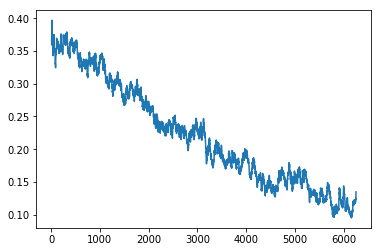

In [74]:
learn.sched.plot_loss()

In [ ]:
learn.save('clas_2')

In [82]:
learn.fit(lrs, 0, wds=wd, cycle_len=14, use_clr=(32,10))

1it [00:11, 11.62s/it, loss=0.091] epoch      trn_loss   val_loss   accuracy   
    0      0.091031   0.208004   0.927303  



[0.20800437038539124, 0.9273032629558541]

In [ ]:
learn.fit(lrs, 1, wds=wd, cycle_len=14, use_clr=(32,10))

 43%|████▎     | 450/1042 [1:22:06<1:48:00, 10.95s/it, loss=0.0897]

From original Jeremy's notebook: *The previous state of the art result was 94.1% accuracy (5.9% error). With bidir we get 95.4% accuracy (4.6% error).*

Note: Since we have trained a weaker LM model(only 100 rows) and run fewer epochs on the classifier, we get lesser accuracy than Jeremy - But will more LM finetuning & more classifier training it should be possible to achieve the 94.7% accuracy.

***This notebook will be continuously updated with more information - If you spotted any errors in the descriptions, please notify @narvind2003 in the fast.ai forums. Thanks!***

## Backwards

**tbd: reverse the data tokens and train a backwards model - just like a bidirectional RNN and use the avg(forward preds, backward preds) should yield much better accuracy **